In [142]:
!pip3 install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 2.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [165]:
import torchvision
from torchvision import datasets, transforms
import torch
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import scipy.io
import wandb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import cv2

In [146]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)

total_samples = len(trainset)
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [147]:
X_train = trainset.data
y_train = trainset.targets

X_test = testset.data
y_test = testset.targets

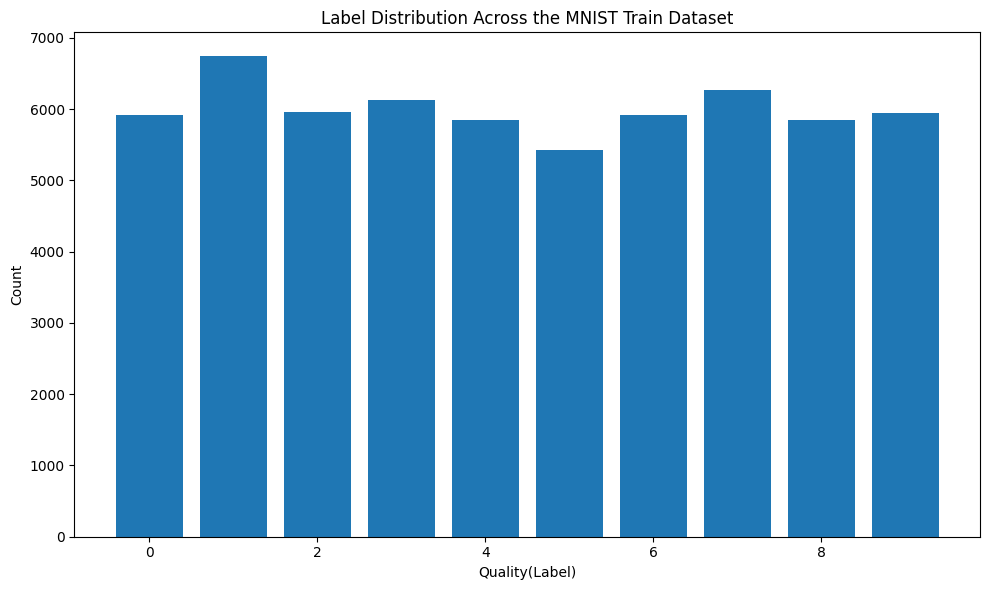

In [149]:
unique_labels, label_counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)

plt.xlabel('Quality(Label)')
plt.ylabel('Count')
plt.title('Label Distribution Across the MNIST Train Dataset')

plt.tight_layout()
plt.show()

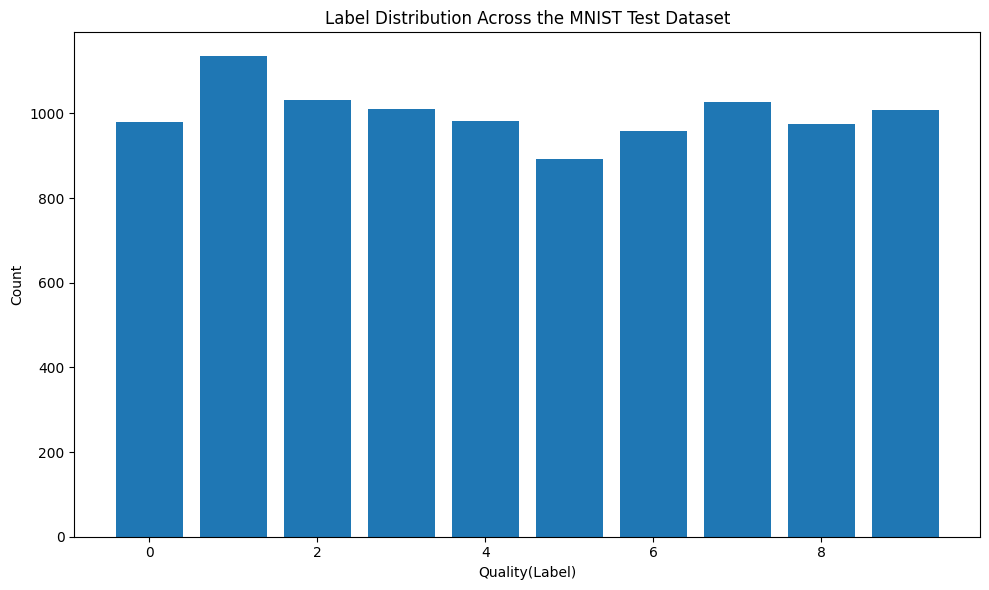

In [150]:
unique_labels, label_counts = np.unique(y_test, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)

plt.xlabel('Quality(Label)')
plt.ylabel('Count')
plt.title('Label Distribution Across the MNIST Test Dataset')

plt.tight_layout()
plt.show()

In [151]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

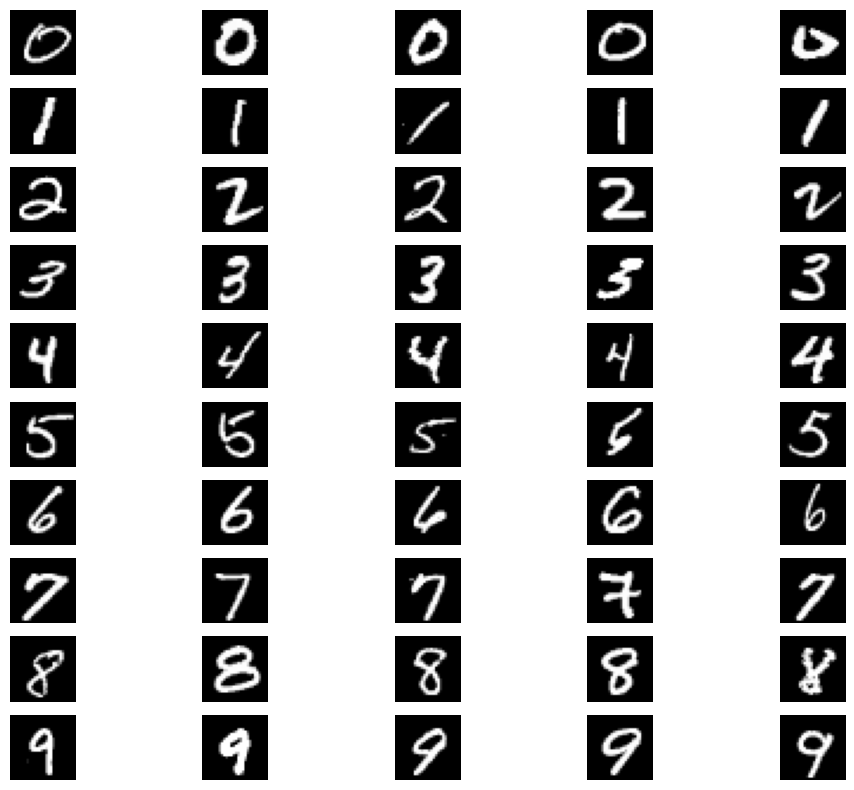

In [152]:
samples_per_class = 5

fig, axes = plt.subplots(10, samples_per_class, figsize=(12, 10))

for label in range(10):
    label_indices = (y_train == label).nonzero()[:samples_per_class].squeeze()
    
    for i, idx in enumerate(label_indices):
        image = X_train[idx].numpy()
        ax = axes[label, i]
        ax.imshow(image, cmap='gray')
        ax.axis('off')

plt.show()

In [169]:
# Chatgpt: Write code plot feature map for a layer in MNIST

def plot_feature_maps(model, input_image, layer_num, target_size=(64, 64)):
    activation = None

    def hook_fn(module, input, output):
        nonlocal activation
        activation = output

    model.conv1.register_forward_hook(hook_fn)
    model.eval()

    with torch.no_grad():
        model(input_image.unsqueeze(0))  # Unsqueezing to add a batch dimension

    feature_maps = activation[0].cpu().numpy()
    
    # Resize the feature maps
    resized_feature_maps = []
    for i in range(feature_maps.shape[0]):
        resized_feature_map = cv2.resize(feature_maps[i], target_size)
        resized_feature_maps.append(resized_feature_map)
    resized_feature_maps = np.array(resized_feature_maps)

    # Normalize the feature maps
    min_val = resized_feature_maps.min()
    max_val = resized_feature_maps.max()
    normalized_feature_maps = (resized_feature_maps - min_val) / (max_val - min_val)

    # Plot the normalized and resized feature maps as subplots
    num_feature_maps = normalized_feature_maps.shape[0]
    plt.figure(figsize=(12, 6))
    for i in range(num_feature_maps):
        plt.subplot(1, num_feature_maps, i + 1)
        plt.imshow(normalized_feature_maps[i], cmap='viridis')
        plt.axis('off')
    # plt.suptitle(f'Feature Maps for Layer {layer_num}')
    plt.show()

In [172]:
# ChatGPT Code: Write CNN Class using kernel size and dropout rate with 2 Conv layers, 1 dropout layer ...

class CNNModel(nn.Module):
    def __init__(self, kernel_sz=3, dropout_rate=0.25, stride=1):
        super(CNNModel, self).__init__()  
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_sz, padding=(kernel_sz-1)//2, stride=stride)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_sz, padding=(kernel_sz-1)//2, stride=stride)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10) 
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [155]:
model = CNNModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    correct_val = 0
    total_val = 0
    val_loss = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader)}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch 1, Train Loss: 0.18607380876069268, Train Accuracy: 94.37%
Epoch 1, Validation Loss: 0.06766014455252901, Validation Accuracy: 97.96%
Epoch 2, Train Loss: 0.057133763349304596, Train Accuracy: 98.25%
Epoch 2, Validation Loss: 0.05232576870711203, Validation Accuracy: 98.38%
Epoch 3, Train Loss: 0.04017503532053282, Train Accuracy: 98.70%
Epoch 3, Validation Loss: 0.04683771271053008, Validation Accuracy: 98.61%
Epoch 4, Train Loss: 0.032071062058055155, Train Accuracy: 98.97%
Epoch 4, Validation Loss: 0.052042945840475245, Validation Accuracy: 98.49%
Epoch 5, Train Loss: 0.026965535956202075, Train Accuracy: 99.12%
Epoch 5, Validation Loss: 0.04283042409704339, Validation Accuracy: 98.81%
Epoch 6, Train Loss: 0.02304332994000288, Train Accuracy: 99.19%
Epoch 6, Validation Loss: 0.04686798774213109, Validation Accuracy: 98.73%
Epoch 7, Train Loss: 0.01841538984127692, Train Accuracy: 99.38%
Epoch 7, Validation Loss: 0.052529068361996285, Validation Accuracy: 98.67%
Epoch 8, Train 

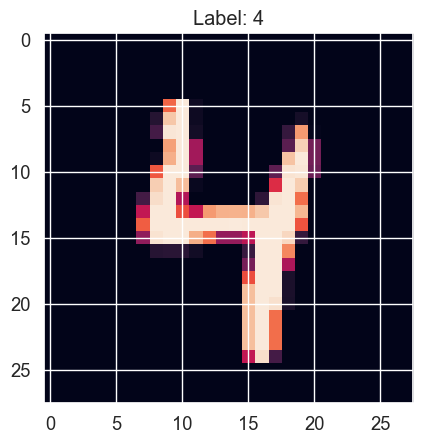

Feature Maps: 


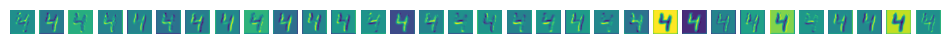

In [171]:
image_index = 0

input_image, input_label = train_dataset[image_index]

plt.imshow(input_image.permute(1, 2, 0))
plt.title(f'Label: {input_label}')
plt.show()

print("Feature Maps: ")
plot_feature_maps(model, input_image, 1)

In [175]:
learning_rates = [0.001, 0.008]
kernel_sizes = [3, 5]
num_epochs = [5, 10]
dropout_rates = [0, 0.25]
strides = [1]

for lr in learning_rates:
    for kernel_sz in kernel_sizes:
        for epochs in num_epochs:
            for dropout_rate in dropout_rates:
                for stride in strides:
                    run = wandb.init(
                        project="SMAI_As3_Q4_1", entity="mitanshkayathwal"
                    )
                    model = CNNModel(kernel_sz, dropout_rate, stride)
                    criterion = nn.CrossEntropyLoss()
                    optimizer = optim.Adam(model.parameters(), lr=0.001)
                    for epoch in range(epochs):
                        model.train()
                        train_loss = 0
                        correct_train = 0
                        total_train = 0
                        correct_val = 0
                        total_val = 0
                        val_loss = 0

                        for images, labels in train_loader:
                            optimizer.zero_grad()
                            outputs = model(images)
                            loss = criterion(outputs, labels)
                            loss.backward()
                            optimizer.step()

                            train_loss += loss.item()
                            _, predicted = outputs.max(1)
                            total_train += labels.size(0)
                            correct_train += predicted.eq(labels).sum().item()

                        with torch.no_grad():
                            for images, labels in val_loader:
                                outputs = model(images)
                                loss = criterion(outputs, labels)
                                val_loss += loss.item()
                                _, predicted = outputs.max(1)
                                total_val += labels.size(0)
                                correct_val += predicted.eq(labels).sum().item()

                        train_loss /= total_train
                        val_loss /= total_val
                        train_accuracy = 100 * correct_train / total_train
                        val_accuracy = 100 * correct_val / total_val

                    wandb.log({
                        'Epochs': epoch,
                        'Learning Rate': lr,
                        'Kernel Size': kernel_sz,
                        'Dropout Rate': dropout_rate,
                        'Stride': stride,
                        'Validation Accuracy': val_accuracy,
                        'Validation Loss': val_loss,
                        'Train Loss': train_loss,
                        'Training Accuracy': train_accuracy,
                    })

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Dropout Rate,▁
Epochs,▁
Kernel Size,▁
Learning Rate,▁
Stride,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Loss,▁
Dropout Rate,0
Epochs,4


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Dropout Rate,▁
Epochs,▁
Kernel Size,▁
Learning Rate,▁
Stride,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Loss,▁
Dropout Rate,0.25
Epochs,4


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Dropout Rate,▁
Epochs,▁
Kernel Size,▁
Learning Rate,▁
Stride,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Loss,▁
Dropout Rate,0
Epochs,9


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Dropout Rate,▁
Epochs,▁
Kernel Size,▁
Learning Rate,▁
Stride,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Loss,▁
Dropout Rate,0.25
Epochs,9


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Dropout Rate,▁
Epochs,▁
Kernel Size,▁
Learning Rate,▁
Stride,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Loss,▁
Dropout Rate,0
Epochs,4


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Dropout Rate,▁
Epochs,▁
Kernel Size,▁
Learning Rate,▁
Stride,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Loss,▁
Dropout Rate,0.25
Epochs,4


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Dropout Rate,▁
Epochs,▁
Kernel Size,▁
Learning Rate,▁
Stride,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Loss,▁
Dropout Rate,0
Epochs,9


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Dropout Rate,▁
Epochs,▁
Kernel Size,▁
Learning Rate,▁
Stride,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Loss,▁
Dropout Rate,0.25
Epochs,9


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Dropout Rate,▁
Epochs,▁
Kernel Size,▁
Learning Rate,▁
Stride,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Loss,▁
Dropout Rate,0
Epochs,4


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Dropout Rate,▁
Epochs,▁
Kernel Size,▁
Learning Rate,▁
Stride,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Loss,▁
Dropout Rate,0.25
Epochs,4


KeyboardInterrupt: 

# Best Hyperparameters found using WandB:

Epochs: 10

Learning Rate: 0.001

Training Loss: 0.0002855

Training Accuracy: 99.34%

Validation Loss: 0.0005603

Validation Accuracy: 99.05%

Kernel Size: 3

Stride: 1

In [177]:
model = CNNModel(3, 0.25, 1)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [180]:
test_accuracy = 0
test_loss = 0
total_test = 0
correct_test = 0

with torch.no_grad():
    for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

test_loss /= total_test
test_accuracy = 100 * correct_train / total_train

print("Loss on Test Dataset is: " + str(test_loss))
print("Accuracy on Test Dataset is: " + str(test_accuracy))

Loss on Test Dataset is: 0.0006436322063585749
Accuracy on Test Dataset is: 99.65


Accuracy on the test set: 99.20%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       1.00      0.98      0.99      1028
           8       0.99      1.00      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Class 0 - Accuracy: 99.59%
Class 1 - Accuracy: 99.38%
Class 2 - Accuracy: 99.03%
Class 3 - Accuracy: 99.41%
Class 4 - Accuracy: 99.59%
Class 5 - Accuracy: 99.22%
Class 6 - Accuracy: 99.

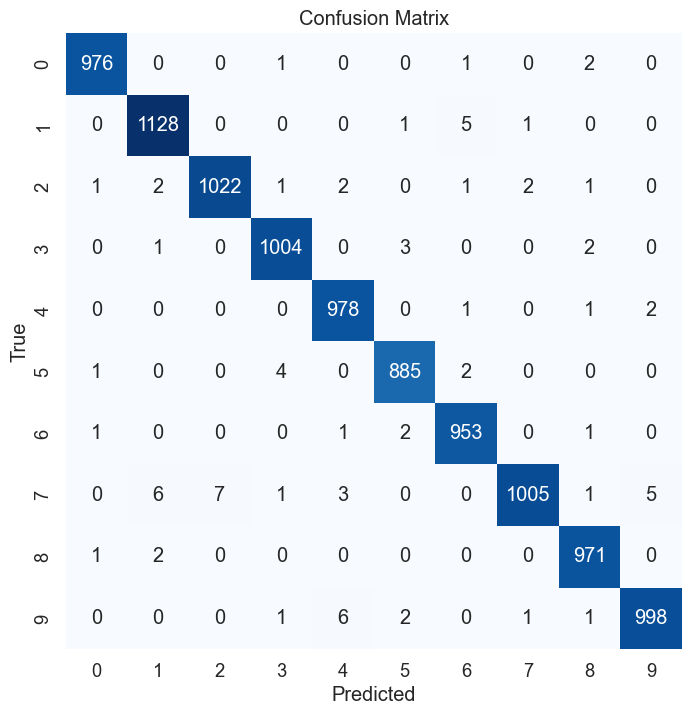

In [156]:
# ChatGPT Code: Write code to evaluate classification report, confusion matrix on CNN

model.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Evaluate the model on the test set
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

# Generate a classification report
class_names = [str(i) for i in range(10)]  # Assuming classes are labeled from 0 to 9
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

# Calculate and print per-class accuracy
cm = confusion_matrix(true_labels, predicted_labels)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, class_name in enumerate(class_names):
    print(f'Class {class_name} - Accuracy: {per_class_accuracy[i] * 100:.2f}%')

class_names = [str(i) for i in range(10)]  

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
                    xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, class_names)

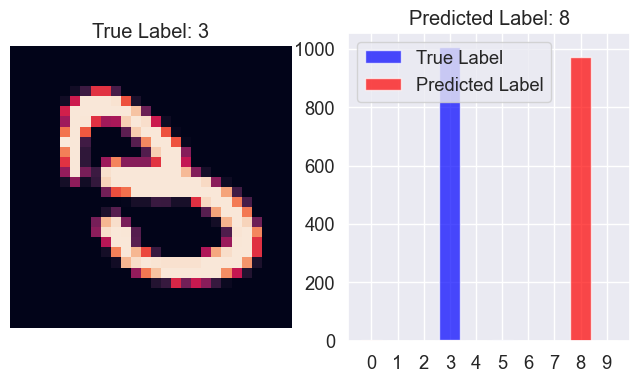

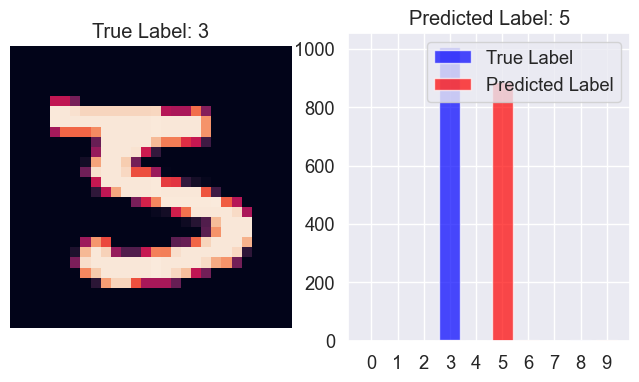

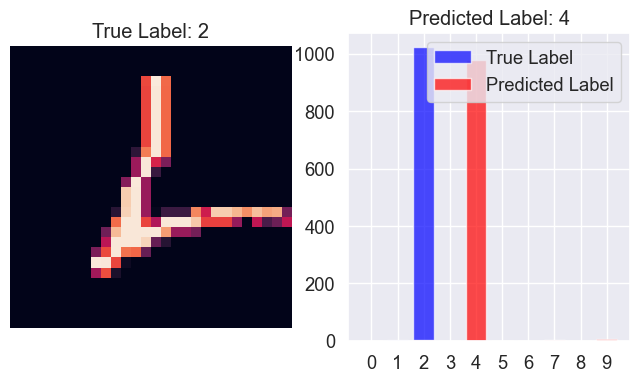

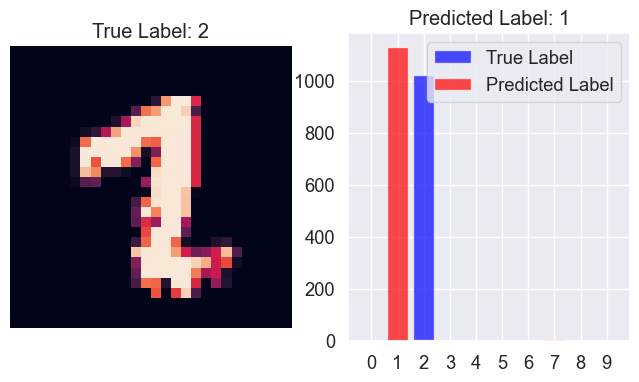

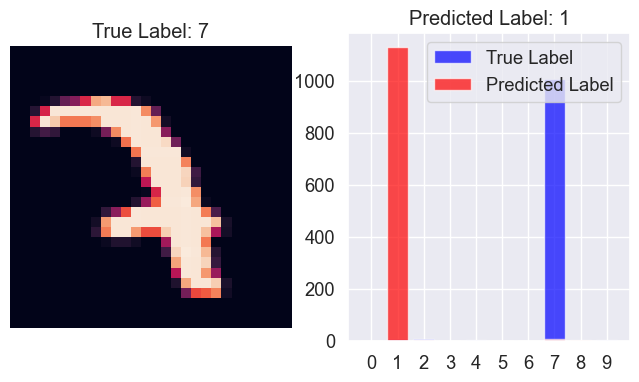

In [158]:
# CHATGPT: Evaluate your best model on the test set and report accuracy, per-class
# accuracy, and classification report.Provide a clear visualization of the model’s performance, e.g., confusion
# matrix. Identify a few instances where the model makes incorrect predictions and
# analyze possible reasons behind these misclassifications.

misclassified_indices = np.where(np.array(true_labels) != np.array(predicted_labels))[0]

num_examples_to_show = 5

for i in range(num_examples_to_show):
    index = misclassified_indices[i]
    
    misclassified_image = testset[index][0]
    true_label = true_labels[index]
    predicted_label = predicted_labels[index]
    
    misclassified_image = misclassified_image.permute(1, 2, 0).numpy()
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(misclassified_image)
    plt.title(f'True Label: {class_names[true_label]}')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.bar(class_names, cm[true_label], color='blue', alpha=0.7, label='True Label')
    plt.bar(class_names, cm[:, predicted_label], color='red', alpha=0.7, label='Predicted Label')
    plt.title(f'Predicted Label: {class_names[predicted_label]}')
    plt.legend()
    plt.show()

Possible reasons behind the misclassifications can be 

1) The model may have overfit to the training data, leading to poor generalization on unseen examples.
2) Inconsistent or inadequate data preprocessing can affect the model's performance.
3) The dataset might contain ambiguous or challenging examples that are difficult to classify correctly.

In [50]:
noisy_data = scipy.io.loadmat('mnist-with-awgn.mat')

In [77]:
X_train = noisy_data['train_x']
y_train = noisy_data['train_y']
X_test = noisy_data['test_x']
y_test = noisy_data['test_y']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

In [85]:
X_train = X_train.reshape(X_train.shape[0],28,28)
X_test = X_test.reshape(X_test.shape[0],28,28)
X_val = X_val.reshape(X_val.shape[0],28,28)

In [88]:
train_dataset = TensorDataset(torch.from_numpy(X_train).float().unsqueeze(1), torch.from_numpy(y_train).float())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(torch.from_numpy(X_val).float().unsqueeze(1), torch.from_numpy(y_val).float())
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(torch.from_numpy(X_test).float().unsqueeze(1), torch.from_numpy(y_test).float())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [89]:
model = CNNModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [102]:
test_accuracy = 0
total_test = 0
correct_test = 0

with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            _, actual = labels.max(1)
            correct_test += (predicted==actual).sum().item()
            total_test += labels.size(0)

test_accuracy = 100 * correct_test / total_test

print("Accuracy on Test-set is: " + str(test_accuracy))

Accuracy on Test-set is: 94.01


In [60]:
def add_gaussian_noise(tensor, std_dev=0.2):
    noise = torch.randn(tensor.size()) * std_dev
    noisy_tensor = tensor + noise
    return noisy_tensor

In [16]:
noisy_train_data = []

for images, labels in trainset:
    noisy_images = add_gaussian_noise(images)
    noisy_train_data.append((noisy_images, labels))

noisy_test_data = []
for images, labels in testset:
    noisy_images = add_gaussian_noise(images)
    noisy_test_data.append((noisy_images, labels))

In [67]:
# ChatGPT Code: Write class for Autoencoder using encoder and decoder

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)

In [68]:
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0
    for images, _ in train_loader:
        optimizer.zero_grad()
        noisy_images = add_gaussian_noise(images)
        outputs = autoencoder.forward(noisy_images)
        loss = criterion(outputs, noisy_images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Autoencoder - Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')    

Autoencoder - Epoch 1, Loss: 0.9439022578398386
Autoencoder - Epoch 2, Loss: 0.8750552731355031
Autoencoder - Epoch 3, Loss: 0.873379889647166
Autoencoder - Epoch 4, Loss: 0.8723904012044271
Autoencoder - Epoch 5, Loss: 0.8717883149782817
Autoencoder - Epoch 6, Loss: 0.871034840186437
Autoencoder - Epoch 7, Loss: 0.8704863425890604
Autoencoder - Epoch 8, Loss: 0.8699300248622894
Autoencoder - Epoch 9, Loss: 0.8695492006142934
Autoencoder - Epoch 10, Loss: 0.86949715924263


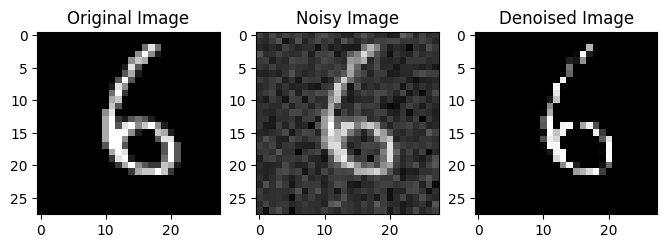

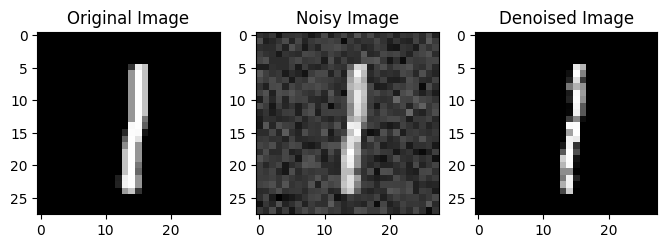

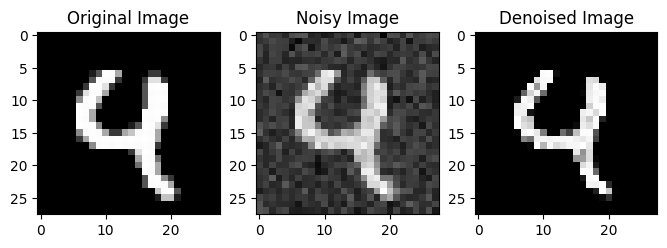

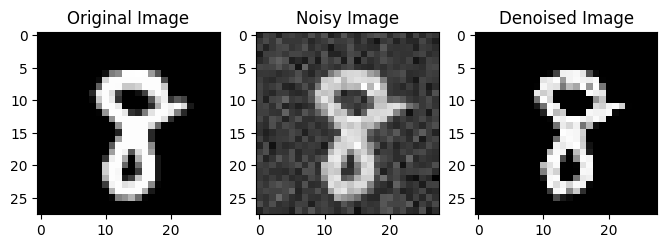

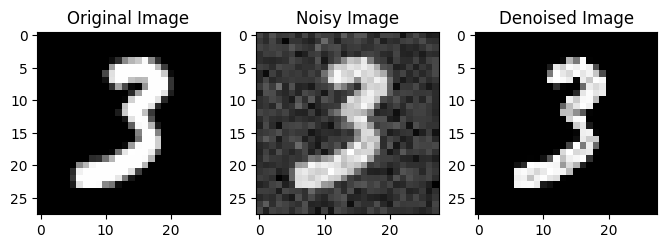

In [70]:
# ChatGPT Code: Write code to plot some images before and after denoising

autoencoder.eval()
cnt = 0
with torch.no_grad():
    for images, _ in train_loader:
        noisy_images = add_gaussian_noise(images)
        denoised_images = autoencoder(noisy_images)

        # Visualize a few examples
        original_image = images[0].squeeze().numpy()
        noisy_image = noisy_images[0].squeeze().numpy()
        denoised_image = denoised_images[0].squeeze().numpy()

        plt.figure(figsize=(8, 4))
        plt.subplot(131)
        plt.title('Original Image')
        plt.imshow(original_image, cmap='gray')
        plt.subplot(132)
        plt.title('Noisy Image')
        plt.imshow(noisy_image, cmap='gray')
        plt.subplot(133)
        plt.title('Denoised Image')
        plt.imshow(denoised_image, cmap='gray')
        plt.show()
        cnt = cnt + 1
        if (cnt==5):
            break

In [136]:
# Write class for classifier to evaluate the denoised data

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [118]:
encoded_train_data = []
train_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        noisy_images = images
        encoded_images = autoencoder.encoder(noisy_images)
        encoded_train_data.append(encoded_images)
        train_labels.append(labels)

encoded_train_data = torch.cat(encoded_train_data)
train_labels = torch.cat(train_labels)

In [126]:
encoded_val_data = []
val_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        noisy_images = images
        encoded_images = autoencoder.encoder(noisy_images)
        encoded_val_data.append(encoded_images)
        val_labels.append(labels)

encoded_val_data = torch.cat(encoded_val_data)
val_labels = torch.cat(val_labels)

In [127]:
encoded_test_data = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        noisy_images = images
        encoded_images = autoencoder.encoder(noisy_images)
        encoded_test_data.append(encoded_images)
        test_labels.append(labels)

encoded_test_data = torch.cat(encoded_test_data)
test_labels = torch.cat(test_labels)

In [128]:
enctrain_dataset = TensorDataset(encoded_train_data, train_labels)
enctrain_loader = torch.utils.data.DataLoader(enctrain_dataset, batch_size=64, shuffle=True)

encval_dataset = TensorDataset(encoded_val_data, val_labels)
encval_loader = torch.utils.data.DataLoader(encval_dataset, batch_size=64, shuffle=True)

enctest_dataset = TensorDataset(encoded_test_data, test_labels)
enctest_loader = torch.utils.data.DataLoader(enctest_dataset, batch_size=64, shuffle=True)

In [138]:
classifier = Classifier()
classifier_criterion = nn.CrossEntropyLoss()
classifier_optimizer = optim.Adam(classifier.parameters(), lr=0.001)

num_classifier_epochs = 10
for epoch in range(num_classifier_epochs):
    classifier.train()
    running_loss = 0.0
    for encoded_images, labels in enctrain_loader:
        classifier_optimizer.zero_grad()
        outputs = classifier(encoded_images)
        loss = classifier_criterion(outputs, labels)
        loss.backward()
        classifier_optimizer.step()
        running_loss += loss.item()

    print(f'Classifier - Epoch {epoch + 1}, Loss: {running_loss / len(testset)}')

Classifier - Epoch 1, Loss: 0.3787223023056984
Classifier - Epoch 2, Loss: 0.09680984156131744
Classifier - Epoch 3, Loss: 0.08428512665629387
Classifier - Epoch 4, Loss: 0.07177501795887947
Classifier - Epoch 5, Loss: 0.05626385898888111
Classifier - Epoch 6, Loss: 0.05109011277854442
Classifier - Epoch 7, Loss: 0.048553699827194215
Classifier - Epoch 8, Loss: 0.049041229677200315
Classifier - Epoch 9, Loss: 0.04793358978331089
Classifier - Epoch 10, Loss: 0.04664550286829472


In [140]:
classifier.eval()
correct = 0
total = 0

with torch.no_grad():
    for encoded_images, labels in enctest_loader:
        outputs = classifier(encoded_images)
        _, predicted = outputs.max(1)
        _, actual = labels.max(1)
        total += labels.size(0)
        correct += (predicted == actual).sum().item()

test_accuracy = 100 * correct / total
print(f'Classifier Test Accuracy: {test_accuracy:.2f}%')

Classifier Test Accuracy: 78.91%
